## VAEs- Deep Unsupervised Learning Project

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
import time

### Import libraries
### Choose device
### Define transformations
### Load datasets
### Inspect a batch (for understanding)
### Visualize sample images (for understanding)

In [3]:
# Choose device

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


100%|██████████| 26421880/26421880 [00:00<00:00, 121664235.28it/s]


Extracting Data_FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to Data_FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5298531.18it/s]

Extracting Data_FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Data_FashionMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 63692069.27it/s]


Extracting Data_FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Data_FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23118069.58it/s]


Extracting Data_FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Data_FashionMNIST/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:00<00:00, 117006229.24it/s]


Extracting DATA_FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to DATA_FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5556822.09it/s]

Extracting DATA_FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to DATA_FashionMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61046915.36it/s]


Extracting DATA_FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to DATA_FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19487614.61it/s]

Extracting DATA_FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_FashionMNIST/FashionMNIST/raw



In [4]:
def visualize_reconstructed_batch(model, data, reconstructed_data):
    # Get a grid of images from the batch
    images = data.view(-1, 28, 28)
    reconstructed_images = reconstructed_data.view(-1, 28, 28)

    # Ajustar el tamaño de la cuadrícula
    fig, axs = plt.subplots(2, len(images), figsize=(10, 5))

    # Verificar la lógica de indexación
    for i in range(len(reconstructed_images)):
        axs[0, i].imshow(images[i].detach().numpy(), cmap="gray")  # Salia un error relacionado a arrays, añadió detach() y numpy()
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        axs[1, i].imshow(reconstructed_images[i].detach().numpy(), cmap="gray")  # Se añadió detach() y numpy()
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')

    fig.suptitle("Sample Reconstructed Images")
    plt.tight_layout()
    plt.show()



In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, num_hidden=8):
        super().__init__()

        # Set the number of hidden units
        self.num_hidden = num_hidden

        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),  # input size: 784, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(512, 256),  # input size: 784, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, self.num_hidden),  # input size: 64, output size: num_hidden
            nn.ReLU(),  # apply the ReLU activation function
        )

        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # input size: num_hidden, output size: 64
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, 512),  # input size: 64, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(512, 784),  # input size: 256, output size: 784
            nn.Sigmoid(),  # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded

In [6]:
class VAE(AutoEncoder):
    def __init__(self, num_hidden=8):
        super().__init__(num_hidden=num_hidden)
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)

        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)

        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder

        encoded = self.encoder(x)

        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)

        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)

        # Pass the latent variable through the decoder
        decoded = self.decoder(z)

        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)

            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)

        # Return the generated samples
        return samples

In [7]:
# Define a loss function that combines MSE and Kullback-Leibler divergence
def vae_loss_function(recon_x, x, mu, logvar, lamb=3):
    # Compute the MSE loss between the reconstructed output and the input data
    MSE = F.mse_loss(recon_x, x.view(-1, 784), reduction="sum")

    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine the two losses by adding them together and return the result
    return MSE + lamb * KLD

In [8]:
def train_vae(model, batch_size=64, learning_rate=1e-3, num_epochs=30):
    # Convert the training data to PyTorch tensors


    #X_train = torch.from_numpy(X_train_np)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Create a DataLoader to handle batching of the training data
    #train_loader = torch.utils.data.DataLoader(
    #    X_train, batch_size=batch_size, shuffle=True
    #)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (data,_) in enumerate(trainLoader):
            # Get a batch of training data and move it to the device
            data = data.reshape(data.size(0),-1)
            data = data.to(device)

            # Forward pass
            encoded, decoded, mu, log_var = model(data)

            # Compute the loss and perform backpropagation
            loss = vae_loss_function(decoded, data, mu, log_var, lamb=3)/len(data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(trainLoader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

In [9]:
model = VAE(num_hidden=64)
train_vae(model)

Epoch 1/30: loss=518.3532
Epoch 2/30: loss=502.8061
Epoch 3/30: loss=497.9825
Epoch 4/30: loss=495.8291
Epoch 5/30: loss=494.7516
Epoch 6/30: loss=494.2319
Epoch 7/30: loss=493.9650
Epoch 8/30: loss=493.6891
Epoch 9/30: loss=493.5213
Epoch 10/30: loss=493.3166
Epoch 11/30: loss=493.0925
Epoch 12/30: loss=493.0122
Epoch 13/30: loss=492.9097
Epoch 14/30: loss=492.7633
Epoch 15/30: loss=492.6042
Epoch 16/30: loss=492.5415
Epoch 17/30: loss=492.4877
Epoch 18/30: loss=492.3303
Epoch 19/30: loss=492.2801
Epoch 20/30: loss=492.2241
Epoch 21/30: loss=492.1544
Epoch 22/30: loss=491.9998
Epoch 23/30: loss=491.9310
Epoch 24/30: loss=491.7876
Epoch 25/30: loss=491.5124
Epoch 26/30: loss=491.1753
Epoch 27/30: loss=490.9961
Epoch 28/30: loss=490.9226
Epoch 29/30: loss=490.7370
Epoch 30/30: loss=490.7724


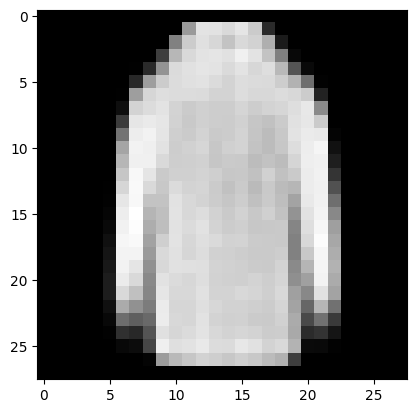

In [10]:
model.eval()

decoded = model.sample(1).view(-1, 28, 28).squeeze().cpu().numpy()

plt.imshow(decoded, cmap="gray")
plt.show()

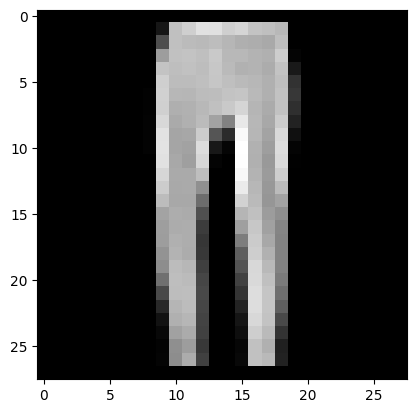

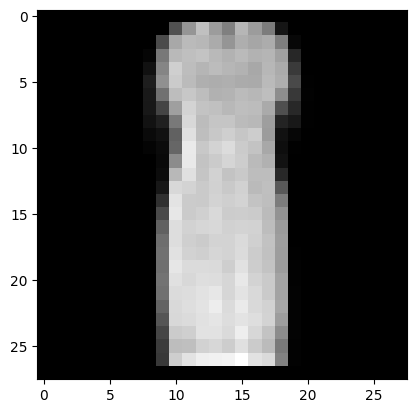

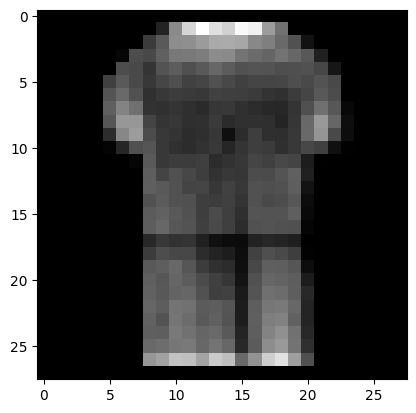

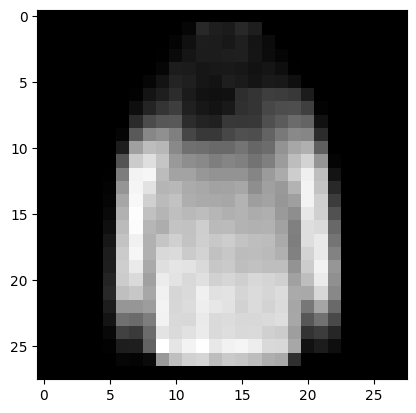

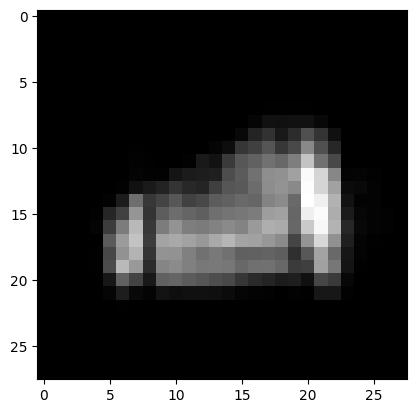

In [11]:
# Set number of images to print
num_images = 5

# Loop to generate and display images
for _ in range(num_images):
  model.eval()
  decoded = model.sample(1).view(-1, 28, 28).squeeze().cpu().numpy()
  plt.imshow(decoded, cmap="gray")
  plt.show()

In [12]:
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
  (mu): Linear(in_features=64, out_features=64, bias=True)
  (log_var): Linear(in_features=64, out_features=64, bias=True)
)

Original images


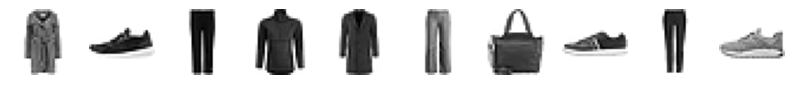

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 784x512)

In [17]:
# Get a batch of test images
dataiter = iter(testLoader)
images, labels = next(dataiter)

# Show original images
plt.figure(figsize=(10, 4))
print('Original images')
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.show()

# Show reconstructed images
with torch.no_grad():
    model.eval()
    images = images.to(device)
    _,outputs = model(images)
    outputs = outputs.cpu()
    plt.figure(figsize=(10, 4))
    print('Reconstructed images')
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(outputs[i].numpy().squeeze(), cmap='gray_r')
        plt.axis('off')
    plt.show()